## TW9: Neural Networks

### Set up

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_blobs

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "NN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility functions

In [2]:
def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()
    

## Part 0

### Neural networks: Classification


- We will work on some of cells togeter

- Understand the results

### Activation functions

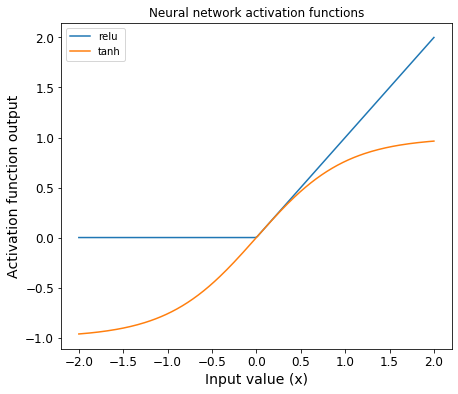

In [3]:
xrange = np.linspace(-2, 2, 200)

plt.figure(figsize=(7,6))

# three commonly used activation functions, relu, tanh, and logistic

plt.plot(xrange, np.maximum(xrange, 0), label='relu')
plt.plot(xrange, np.tanh(xrange), label='tanh')


plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')

plt.show()

### Synthetic dataset 1: single hidden layer

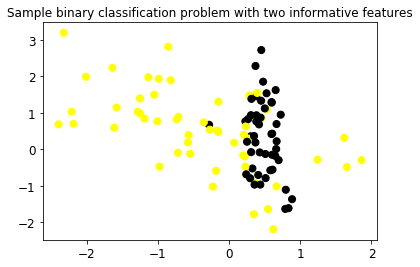

In [4]:
# synthetic dataset for classification (binary)
plt.figure()
plt.title('Sample binary classification problem with two informative features')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)

plt.scatter(X_C2[:, 0], X_C2[:, 1], marker= 'o', c=y_C2, s=50, cmap=cmap_bold)
plt.show()

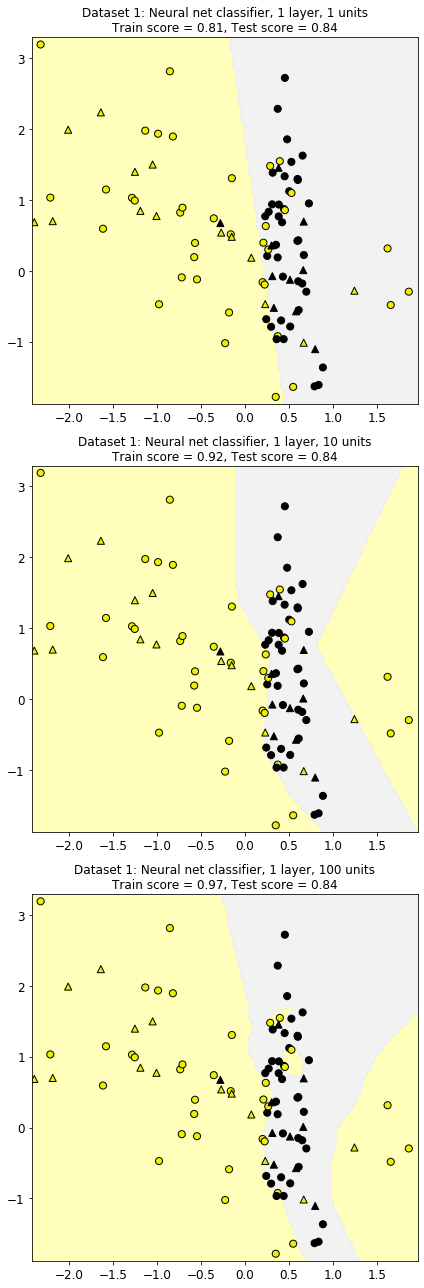

In [5]:
# MLPclassifier
from sklearn.neural_network import MLPClassifier



fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state=0)

for units, axis in zip([1, 10, 100], subaxes):
    # model training with one hidden layer
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs',random_state=0).fit(X_train, y_train)
    
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Synthetic dataset 2: single hidden layer

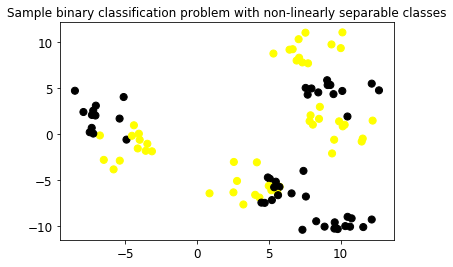

In [6]:
# more difficult synthetic dataset for classification (binary)
# with classes that are not linearly separable
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2,
                       centers = 8, cluster_std = 1.3,
                       random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

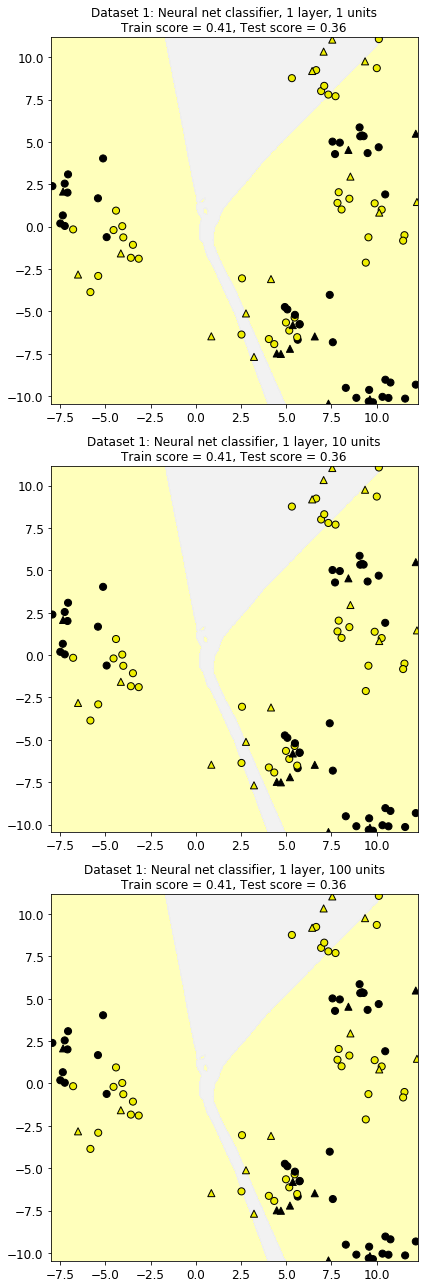

In [7]:
from sklearn.neural_network import MLPClassifier

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

for units, axis in zip([1, 10, 100], subaxes):
    # model training with one hidden layer
    
    
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Synthetic dataset 2: two hidden layers

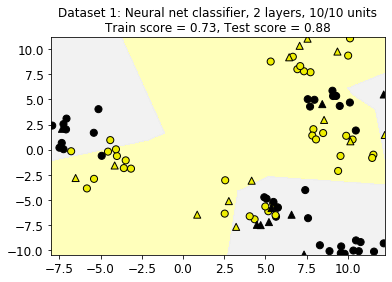

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

# model training with two hidden layers
    
nnclf = MLPClassifier(hidden_layer_sizes = [8,8], solver='lbfgs',random_state=0).fit(X_train, y_train)




plot_class_regions_for_classifier(nnclf, X_train, y_train, X_test, y_test,
                                 'Dataset 1: Neural net classifier, 2 layers, 10/10 units')

#### Regularization parameter: alpha

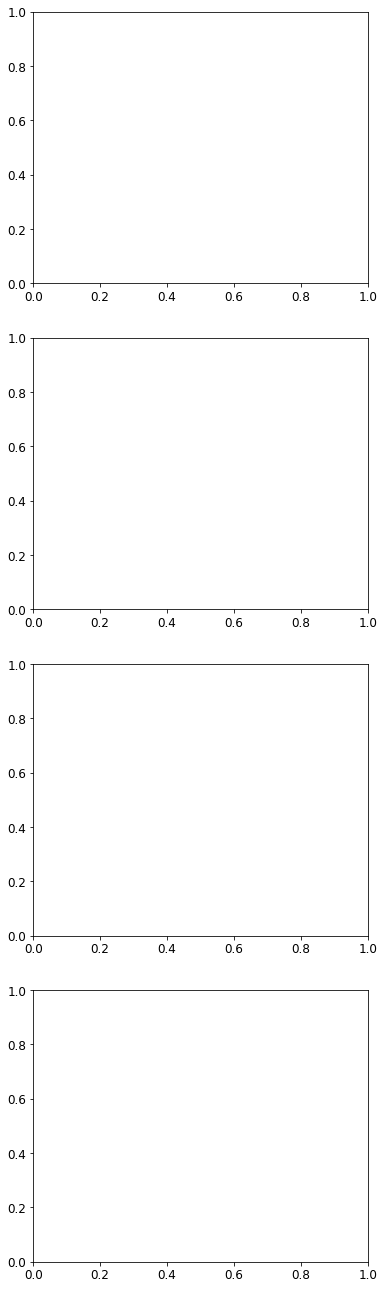

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([       ], subaxes):
    # training the data

    
    
    
    
    
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()
    

#### The effect of different choices of activation function

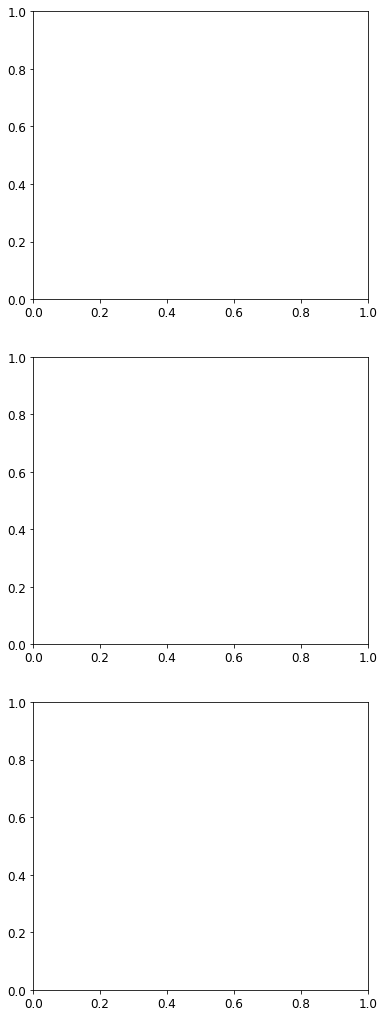

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for this_activation, axis in zip([], subaxes):

    
    
    
    
    
    
    
    title = 'Dataset 2: NN classifier, 2 layers 10/10, {} \
activation function'.format(this_activation)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Neural networks: Regression

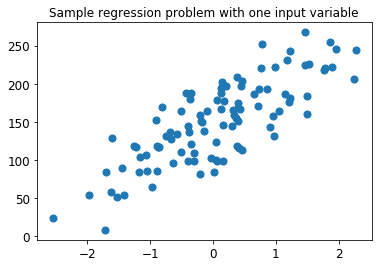

In [11]:
# synthetic dataset for simple regression
from sklearn.datasets import make_regression

plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

C:\Users\aboss\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\aboss\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\aboss\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

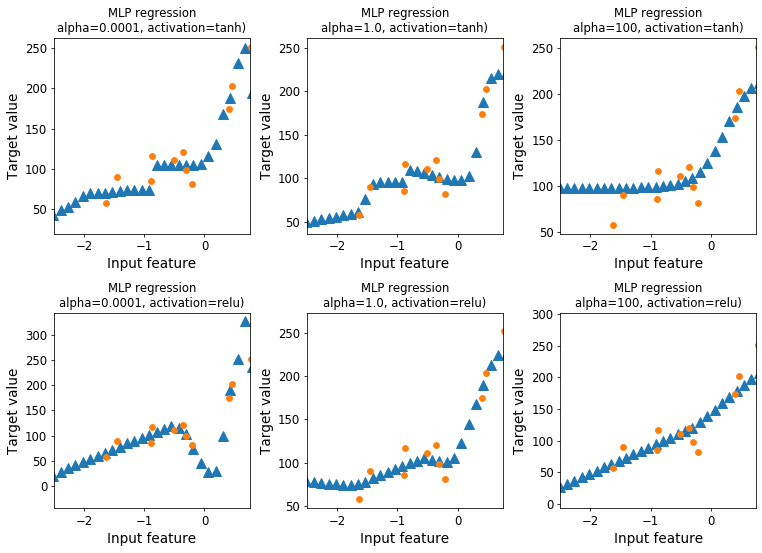

In [12]:
from sklearn.neural_network import MLPRegressor

fig, subaxes = plt.subplots(2, 3, figsize=(11,8), dpi=70)

X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        thisaxis.set_xlim([-2.5, 0.75])
        thisaxis.plot(X_predict_input, y_predict_output,
                     '^', markersize = 10)
        thisaxis.plot(X_train, y_train, 'o')
        thisaxis.set_xlabel('Input feature')
        thisaxis.set_ylabel('Target value')
        thisaxis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(thisalpha, thisactivation))
        plt.tight_layout()

## Part 1

### Application to real-world dataset for classification

1. Breast cancer dataset

2. Fruit dataset

For each dataset, 

- apply neural network with 2 hidden layers with varying number of units (10, 20, 50, 100). 

- find out the optimla alpha parameter value for regularization. 

- apply different activation functions (logistic, tanh, relu) and show the effect.

- compare the results without scaling and with scaling. 


## Part 2

- Write a short summary of your analysis result of neural networks (submitted on Canvas). 

- Provide a link to the notebook on Github.

### 1. Breast Cancer dataset

In [1]:
# Breast cancer dataset for classification
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_blobs

cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

#### Cells of your analysis will be added below. 

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [10, 20], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [20, 50], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [50, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [10, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97
Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97
Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97
Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97


In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = MLPClassifier(hidden_layer_sizes = [10, 20], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [20, 50], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [50, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [10, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.37
Accuracy of NN classifier on test set: 0.37
Breast cancer dataset
Accuracy of NN classifier on training set: 0.37
Accuracy of NN classifier on test set: 0.37
Breast cancer dataset
Accuracy of NN classifier on training set: 0.37
Accuracy of NN classifier on test set: 0.37
Breast cancer dataset
Accuracy of NN classifier on training set: 0.36
Accuracy of NN classifier on test set: 0.36


In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [10, 10], activation='logistic', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [20, 20], activation='logistic', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [50, 50], activation='logistic', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [100, 100], activation='logistic', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.63
Accuracy of NN classifier on test set: 0.63
Breast cancer dataset
Accuracy of NN classifier on training set: 0.63
Accuracy of NN classifier on test set: 0.63
Breast cancer dataset
Accuracy of NN classifier on training set: 0.63
Accuracy of NN classifier on test set: 0.63
Breast cancer dataset
Accuracy of NN classifier on training set: 0.63
Accuracy of NN classifier on test set: 0.63


In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [10, 10], activation='tanh', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [20, 20], activation='tanh', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [50, 50], activation='tanh', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [100, 100], activation='tanh', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97
Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97
Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97
Breast cancer dataset
Accuracy of NN classifier on training set: 0.98
Accuracy of NN classifier on test set: 0.97


### 2. Fruit dataset

In [4]:
import numpy as np
import pandas as pd
import os
# fruits dataset
fruits = pd.read_csv('./data/fruit_data_with_colors.txt', sep='\t', engine='python')

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

#### Cells of your analysis will be added below.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_fruits_2d, y_fruits_2d, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [10, 10], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [20, 20], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [50, 50], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


X_train, X_test, y_train, y_test = train_test_split(X_fruits_2d, y_fruits_2d, random_state = 0)

clf = MLPClassifier(hidden_layer_sizes = [10, 20], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [20, 50], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [50, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [10, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_fruits_2d, y_fruits_2d, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [10, 10], activation='logistic', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [20, 20], activation='logistic', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [50, 50], activation='logistic', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [100, 100], activation='logistic', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_fruits_2d, y_fruits_2d, random_state = 0)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [10, 10], activation='tanh', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [20, 20], activation='tanh', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [50, 50], activation='tanh', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

clf = MLPClassifier(hidden_layer_sizes = [100, 100], activation='tanh', alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
Breast cancer dataset
Accuracy of NN classifier on training set: 0.34
Accuracy of NN classifier on test set: 0.27
